# Moving Averages CINGULATE region

This corresponds to the visualization on the first HCP half of the t-SNE and clustering of the two models (first model being run on the first half, the second model being run on the second half of HCP)

# 1) Imports

In [1]:
import os
import glob
import sys
import json
import shutil

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

In [2]:
import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

import torch

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.manifold import TSNE

import matplotlib.cm as cm

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf, DictConfig

In [3]:
# If true, saves meshes as files
save_mesh = False

# If true, saves buckets as files
save_bucket = False

# 2) Functions and datasets

In [4]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(0, len(df.columns))]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [5]:
def mscatter(x, y, ax=None, m=None, **kw):
    if not ax:
        ax = plt.gca()
    sc = ax.scatter(x, y, **kw)
    if (m is not None) and (len(m) == len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [6]:
path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rcrops/'

In [7]:
run_dir = '/host/volatile/jc225751/Runs/33_MIDL_2022_reviews'

In [19]:
csv_dir = '/host/tgcc/hcp'

In [23]:
glob.glob(csv_dir + '/*')

['/host/tgcc/hcp/RAW',
 '/host/tgcc/hcp/hcpreal.md5',
 '/host/tgcc/hcp/PROCESSED',
 '/host/tgcc/hcp/participants.csv',
 '/host/tgcc/hcp/hcpdssi.md5',
 '/host/tgcc/hcp/ANALYSIS',
 '/host/tgcc/hcp/hcpdssisort.md5',
 '/host/tgcc/hcp/hcprealsort.md5',
 '/host/tgcc/hcp/STUDIES',
 '/host/tgcc/hcp/ATLAS',
 '/host/tgcc/hcp/download',
 '/host/tgcc/hcp/hcp.md5']

In [8]:
if torch.cuda.is_available():
    device = "cuda:0"
print(device)

cuda:0


## We load hcp_1 resulta

In [9]:
# We load the embeddings
result_dir = f"{run_dir}/Output/t-0.1/n-004_o-4"
train_val_embeddings_file = f"{result_dir}/train_val_embeddings.pt"
embeddings = torch.load(train_val_embeddings_file)
print(embeddings.shape)

torch.Size([550, 4])


In [339]:
# We load the labels
with open(f"{result_dir}/train_val_filenames.json", 'r') as f:
    subject_labels = json.load(f)
print(subject_labels[0])    

129634


In [31]:
hcp_1 = pd.DataFrame(embeddings.numpy(), index=subject_labels, columns=[1, 2, 3, 4])
hcp_1.head()

,1,2,3,4
129634,-1.579225,5.908354,11.362507,9.859923
136833,-1.279658,7.395753,10.953645,10.460653
206222,-1.124506,1.848059,1.461904,5.974949
138837,-1.068878,5.266653,0.712424,4.285092
987983,-0.843226,3.528162,4.100409,-0.345357


Remove subject '142626'

In [94]:
hcp_1.loc['142626']

1   -1.427535
2    5.330530
3    5.377621
4    8.720008
Name: 142626, dtype: float32

In [96]:
i = hcp_1.loc['142626'].index

In [98]:
hcp_1 = hcp_1.drop(['142626'])

In [102]:
embeddings = hcp_1.iloc[:,0:4].values

In [103]:
embeddings.shape

(549, 4)

In [110]:
subject_labels = hcp_1.index.values

In [111]:
subject_labels.shape

(549,)

## We load hcp_2 results evaluated on model trained on HCP_1

In [338]:
# We load the embeddings from the second half
result_dir2 = f"{run_dir}/Output/t-0.1-evaluate-2nde_half/n-004_o-4"
train_val_embeddings_file2 = f"{result_dir2}/train_val_embeddings.pt"
embeddings2 = torch.load(train_val_embeddings_file2)
print(embeddings2.shape)

torch.Size([551, 4])


In [340]:
# We load the labels
with open(f"{result_dir2}/train_val_filenames.json", 'r') as f:
    subject_labels2 = json.load(f)
print(subject_labels2[0])   

765864


In [347]:
hcp_2 = pd.DataFrame(embeddings2.numpy(), index=subject_labels2, columns=[1, 2, 3, 4])
hcp_2.head()

,1,2,3,4
765864,-1.409215,6.342757,7.173174,9.771157
135124,-0.922071,7.909201,11.159314,9.079297
171330,-1.232468,7.252167,8.289696,9.643506
158540,-1.487865,7.089256,10.448948,11.064758
175338,-1.202766,5.791755,12.472547,6.554699


# 3) T-SNE

In [341]:
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=50)
X_tsne = tsne.fit_transform(embeddings)

In [342]:
tsne2 = TSNE(n_components=2, perplexity=25, init='pca', random_state=50)
X_tsne2 = tsne2.fit_transform(embeddings2)

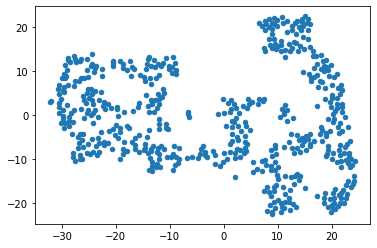

In [343]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], s=20, ax=ax)
plt.show()


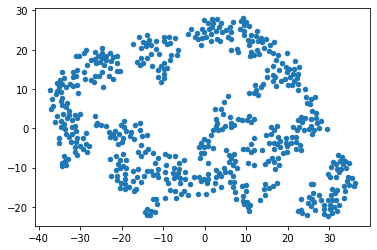

In [344]:
fig, ax = plt.subplots(1)
mscatter(X_tsne2[:, 0], X_tsne2[:, 1], s=20, ax=ax)
plt.show()

In [345]:
X_tsne.shape 

(549, 2)

In [346]:
X_tsne2.shape 

(551, 2)

# Loads HCP csv file

In [26]:
csv_file = f"{csv_dir}/participants.csv"

In [27]:
csv = pd.read_csv(csv_file)

In [45]:
csv.head()

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88


## Merge it with hcp_1

In [46]:
hcp_1.head()

,1,2,3,4
129634,-1.579225,5.908354,11.362507,9.859923
136833,-1.279658,7.395753,10.953645,10.460653
206222,-1.124506,1.848059,1.461904,5.974949
138837,-1.068878,5.266653,0.712424,4.285092
987983,-0.843226,3.528162,4.100409,-0.345357


In [47]:
csv['Flanker_AgeAdj'][0:3]

0    111.01
1    116.55
2    101.90
Name: Flanker_AgeAdj, dtype: float64

In [48]:
hcp_1.index

Index(['129634', '136833', '206222', '138837', '987983', '562345', '182032',
       '275645', '151021', '177342',
       ...
       '395958', '154734', '385046', '200008', '792867', '618952', '433839',
       '188448', '166640', '541943'],
      dtype='object', length=550)

In [52]:
csv.Subject = csv.Subject.astype(str).astype(object)

In [53]:
csv.head()

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100004,S900,Q06,M,22-25,False,0,0,0,0.0,...,5.2,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80
1,100206,S900,Q11,M,26-30,True,1,1,4,100.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
2,100307,Q1,Q01,F,26-30,True,1,1,4,100.0,...,3.6,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76
3,100408,Q3,Q03,M,31-35,True,1,1,4,100.0,...,2.0,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68
4,100610,S900,Q08,M,26-30,True,2,1,4,100.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88


In [81]:
# Checks which subject of hcp_1 is NOT in participants.csv file
hcp_1.index[~hcp_1.index.isin(csv.Subject)]

Index(['142626'], dtype='object')

In [86]:
hcp_1.loc['142626']

1   -1.427535
2    5.330530
3    5.377621
4    8.720008
Name: 142626, dtype: float32

In [93]:
csv[csv.Subject=='142626']

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final


In [54]:
m_1 = pd.merge(hcp_1, csv, left_on=hcp_1.index, right_on=csv.Subject)

In [55]:
m_1.head()

,key_0,1,2,3,4,Subject,Release,Acquisition,Gender,Age,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,129634,-1.579225,5.908354,11.362507,9.859923,129634,S900,Q11,M,22-25,...,4.4,108.79,97.19,0.0,38.6,101.63,101.22,1.80,0.0,1.80
1,136833,-1.279658,7.395753,10.953645,10.460653,136833,Q2,Q02,M,31-35,...,4.4,101.12,87.11,4.0,62.9,96.87,95.48,1.76,1.0,1.72
2,206222,-1.124506,1.848059,1.461904,5.974949,206222,S900,Q10,M,26-30,...,3.6,108.79,98.04,4.0,52.6,98.31,97.68,1.92,0.0,1.92
3,138837,-1.068878,5.266653,0.712424,4.285092,138837,S900,Q11,M,22-25,...,4.4,101.12,86.45,NaN,38.6,111.27,111.33,1.80,0.0,1.80
4,987983,-0.843226,3.528162,4.100409,-0.345357,987983,S500,Q04,F,26-30,...,5.2,108.79,97.19,5.0,56.4,88.02,87.70,1.88,0.0,1.88


In [57]:
m_1 = m_1.set_index('Subject')
m_1 = m_1.drop('key_0', 1)

In [58]:
m_1.head()

,1,2,3,4,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
Subject,,,,,,,,,,,,,,,,,,,,,
129634,-1.579225,5.908354,11.362507,9.859923,S900,Q11,M,22-25,True,2,...,4.4,108.79,97.19,0.0,38.6,101.63,101.22,1.80,0.0,1.80
136833,-1.279658,7.395753,10.953645,10.460653,Q2,Q02,M,31-35,True,1,...,4.4,101.12,87.11,4.0,62.9,96.87,95.48,1.76,1.0,1.72
206222,-1.124506,1.848059,1.461904,5.974949,S900,Q10,M,26-30,True,1,...,3.6,108.79,98.04,4.0,52.6,98.31,97.68,1.92,0.0,1.92
138837,-1.068878,5.266653,0.712424,4.285092,S900,Q11,M,22-25,True,1,...,4.4,101.12,86.45,NaN,38.6,111.27,111.33,1.80,0.0,1.80
987983,-0.843226,3.528162,4.100409,-0.345357,S500,Q04,F,26-30,True,2,...,5.2,108.79,97.19,5.0,56.4,88.02,87.70,1.88,0.0,1.88


In [61]:
hcp_1.shape

(550, 4)

In [60]:
m_1.shape

(549, 386)

In [64]:
X = m_1.iloc[:,0:4].values

## Merge it with hcp_2

In [348]:
# Checks which subject of hcp_1 is NOT in participants.csv file
hcp_2.index[~hcp_2.index.isin(csv.Subject)]

Index([], dtype='object')

In [349]:
m_2 = pd.merge(hcp_2, csv, left_on=hcp_2.index, right_on=csv.Subject)
m_2.head()

,key_0,1,2,3,4,Subject,Release,Acquisition,Gender,Age,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,765864,-1.409215,6.342757,7.173174,9.771157,765864,S1200,Q08,F,26-30,...,2.8,101.12,86.45,1.0,38.6,80.52,80.00,1.80,0.0,1.80
1,135124,-0.922071,7.909201,11.159314,9.079297,135124,S1200,Q13,F,31-35,...,2.8,108.79,98.04,0.0,38.6,109.85,108.80,1.92,0.0,1.92
2,171330,-1.232468,7.252167,8.289696,9.643506,171330,S900,Q09,M,26-30,...,6.8,122.25,110.45,0.0,48.7,116.45,116.67,1.88,1.0,1.84
3,158540,-1.487865,7.089256,10.448948,11.064758,158540,Q2,Q02,M,31-35,...,3.6,108.79,98.04,3.0,50.1,76.41,73.80,1.72,0.0,1.72
4,175338,-1.202766,5.791755,12.472547,6.554699,175338,S900,Q10,F,22-25,...,3.6,108.79,97.19,1.0,38.6,104.66,102.92,1.84,1.0,1.80


In [350]:
m_2 = m_2.set_index('Subject')
m_2 = m_2.drop('key_0', 1)

In [351]:
m_2.head()

,1,2,3,4,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
Subject,,,,,,,,,,,,,,,,,,,,,
765864,-1.409215,6.342757,7.173174,9.771157,S1200,Q08,F,26-30,True,2,...,2.8,101.12,86.45,1.0,38.6,80.52,80.00,1.80,0.0,1.80
135124,-0.922071,7.909201,11.159314,9.079297,S1200,Q13,F,31-35,True,2,...,2.8,108.79,98.04,0.0,38.6,109.85,108.80,1.92,0.0,1.92
171330,-1.232468,7.252167,8.289696,9.643506,S900,Q09,M,26-30,True,1,...,6.8,122.25,110.45,0.0,48.7,116.45,116.67,1.88,1.0,1.84
158540,-1.487865,7.089256,10.448948,11.064758,Q2,Q02,M,31-35,True,2,...,3.6,108.79,98.04,3.0,50.1,76.41,73.80,1.72,0.0,1.72
175338,-1.202766,5.791755,12.472547,6.554699,S900,Q10,F,22-25,True,1,...,3.6,108.79,97.19,1.0,38.6,104.66,102.92,1.84,1.0,1.80


In [360]:
X2 = m_2.iloc[:,0:4].values
X2.shape

(551, 4)

# Regression with Flanker test

In [326]:
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
import seaborn as sns

In [301]:
import statsmodels.api as sm

In [361]:
y_flanker = m_1.Flanker_AgeAdj.values

In [362]:
y_flanker2 = m_2.Flanker_AgeAdj.values

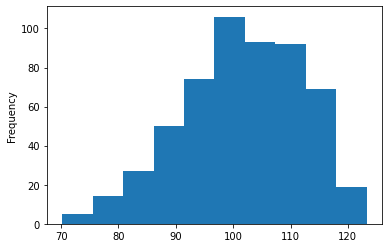

In [310]:
ax = m_1.Flanker_AgeAdj.plot.hist()

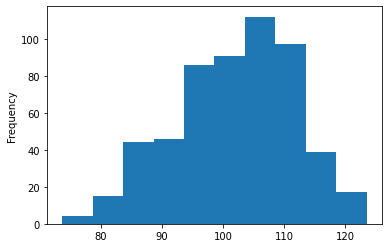

In [353]:
ax2 = m_2.Flanker_AgeAdj.plot.hist()

In [312]:
X.shape

(549, 4)

We use here standards models with ordinary least squares

In [311]:
est = sm.OLS(y_flanker, X)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                              4014.
Date:                Wed, 16 Feb 2022   Prob (F-statistic):                        0.00
Time:                        10:36:26   Log-Likelihood:                         -2380.9
No. Observations:                 549   AIC:                                      4770.
Df Residuals:                     545   BIC:                                      4787.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We now use the SVR from scikit-learn

In [379]:
regr = make_pipeline(SVR(kernel='rbf', gamma='auto', C=1.0, epsilon=0.1))

In [380]:
regr.fit(X, y_flanker)
pred_flanker = regr.predict(X)
regr.score(X, y_flanker)

0.05221694609903926

In [381]:
pred_flanker2 = regr.predict(X2)
regr.score(X2, y_flanker2)

-0.03357384229734439

In [382]:
explained_variance_score(y_flanker, pred_flanker)

0.05772514599456102

In [356]:
r2_score(y_flanker, pred_flanker)

0.05221694609903926

In [324]:
est2.conf_int(alpha=0.05, cols=None)

array([[0.98945895, 1.00594911]])

In [320]:
regr_lin = linear_model.LinearRegression()
regr_lin.fit(y_flanker.reshape(-1, 1), pred_flanker)
lin_flanker = regr_lin.predict(y_flanker.reshape(-1, 1))

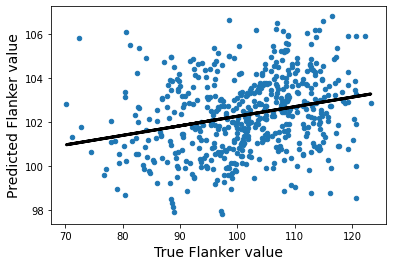

In [383]:
fig, ax = plt.subplots(1)
mscatter(y_flanker, pred_flanker, s=20, ax=ax)
plt.plot(y_flanker, lin_flanker, color="black", linewidth=3)
plt.xlabel(f'True Flanker value', fontsize=14)
plt.ylabel(f'Predicted Flanker value', fontsize=14)
plt.show()

In [384]:
data = sns.load_dataset("tips")
data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


<AxesSubplot:>

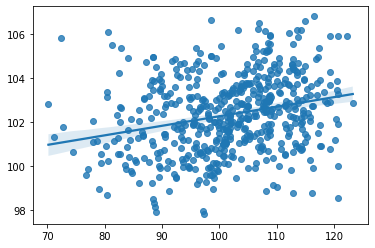

In [385]:
sns.regplot(x=y_flanker, y=pred_flanker)

<AxesSubplot:>

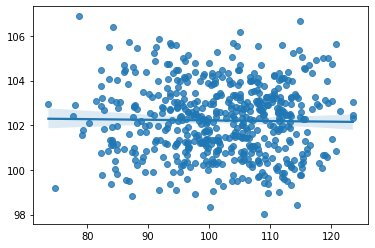

In [386]:
sns.regplot(x=y_flanker2, y=pred_flanker2)

In [215]:
print(subject_labels[-4:-1])
print(m_1.index[-4:-1])

['433839' '188448' '166640']
Index(['433839', '188448', '166640'], dtype='object', name='Subject')


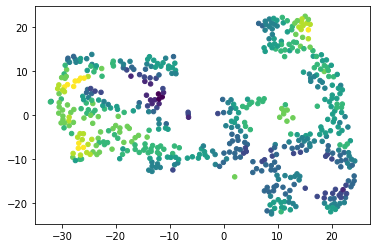

In [313]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=pred_flanker.astype(int), s=20, ax=ax)
plt.show()

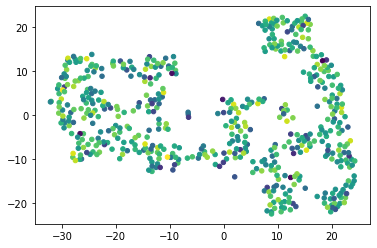

In [216]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=y_flanker.astype(int), s=20, ax=ax)
plt.show()

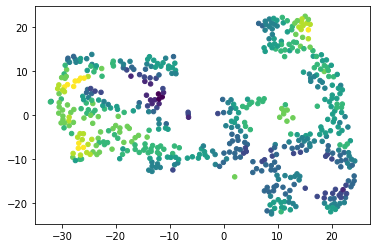

In [217]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=pred_flanker.astype(int), s=20, ax=ax)
plt.show()

In [218]:
y_flanker_class = ((y_flanker-70)/9).astype(int)
np.unique(y_flanker_class)

array([0, 1, 2, 3, 4, 5])

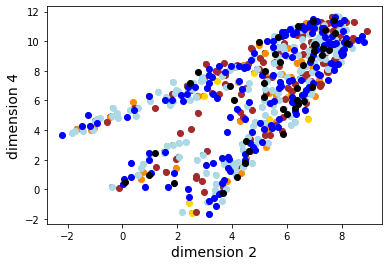

In [219]:
arr = np.array([np.array([m_1[k][i] for k in m_1.columns[[1,3]]]) for i in range(len(m_1))])

fig, ax = plt.subplots()

color_dict = {0: 'gold', 1:'darkorange', 2:'brown', 3:'lightblue', 4:'blue', 5:'black'}

mscatter(arr[:, 0], arr[:, 1], c=((y_flanker-70)/10).astype(int), s=20, ax=ax)

for g in np.unique(y_flanker_class):
    ix = np.where(y_flanker_class == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict[g])

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.show()

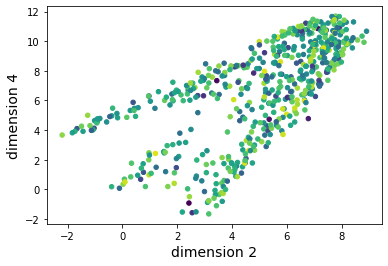

In [292]:
arr = np.array([np.array([m_1[k][i] for k in m_1.columns[[1,3]]]) for i in range(len(m_1))])

fig, ax = plt.subplots()

mscatter(arr[:, 0], arr[:, 1], c=y_flanker, s=20, ax=ax)

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.show()

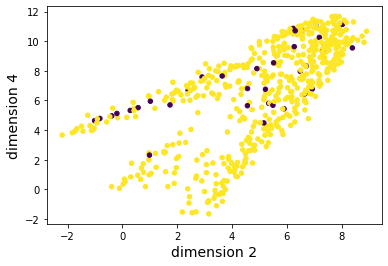

In [220]:
arr = np.array([np.array([m_1[k][i] for k in m_1.columns[[1,3]]]) for i in range(len(m_1))])

fig, ax = plt.subplots()

mscatter(arr[:, 0], arr[:, 1], c=~((y_flanker.astype(int)<99) & (y_flanker.astype(int)>96)), s=20, ax=ax)

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.show()

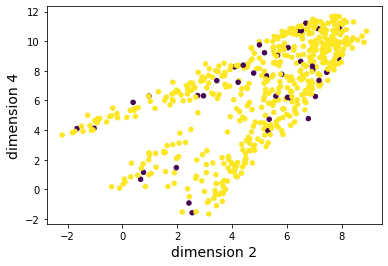

In [244]:
arr = np.array([np.array([m_1[k][i] for k in m_1.columns[[1,3]]]) for i in range(len(m_1))])

fig, ax = plt.subplots()

mscatter(arr[:, 0], arr[:, 1], c=~((y_flanker.astype(int)<85) & (y_flanker.astype(int)>65)), s=20, ax=ax)

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.show()

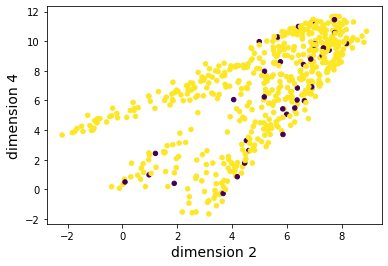

In [247]:
arr = np.array([np.array([m_1[k][i] for k in m_1.columns[[1,3]]]) for i in range(len(m_1))])

fig, ax = plt.subplots()

mscatter(arr[:, 0], arr[:, 1], c=~((y_flanker.astype(int)<130) & (y_flanker.astype(int)>115)), s=20, ax=ax)

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.show()

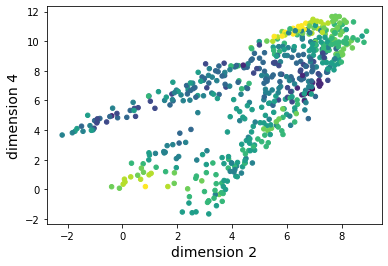

In [222]:
arr = np.array([np.array([m_1[k][i] for k in m_1.columns[[1,3]]]) for i in range(len(m_1))])

fig, ax = plt.subplots()

mscatter(arr[:, 0], arr[:, 1], c=pred_flanker.astype(int), s=20, ax=ax)

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.show()

## Define it as a multiclass proba

In [236]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [233]:
y_high = (y_flanker>115).astype(int)
np.unique(y_high, return_counts=True)

(array([0, 1]), array([506,  43]))

In [284]:
clf_c = make_pipeline(StandardScaler(), svm.SVC(C=1, class_weight='balanced', probability=True))

In [285]:
scores = cross_val_score(clf_c, X, y_high, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.42342342 0.52727273 0.46363636 0.52293578 0.60550459]
0.51 accuracy with a standard deviation of 0.06


In [286]:
y_high[0:3]

array([0, 0, 0])

In [287]:
clf_c = make_pipeline(StandardScaler(), svm.SVC(C=1, class_weight='balanced', probability=True))

In [288]:
y_high_proba = clf_c.fit(X, y_high).predict_proba(X)
y_high_proba[:3,0]

array([0.93490856, 0.92898331, 0.89474984])

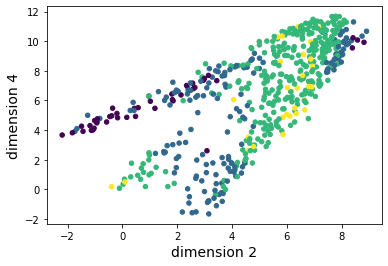

In [289]:
arr = np.array([np.array([m_1[k][i] for k in m_1.columns[[1,3]]]) for i in range(len(m_1))])

fig, ax = plt.subplots()

mscatter(arr[:, 0], arr[:, 1], c=(y_high_proba[:,0]*50).astype(int), s=20, ax=ax)

plt.xlabel(f'dimension 2', fontsize=14)
plt.ylabel(f'dimension 4', fontsize=14)
plt.show()

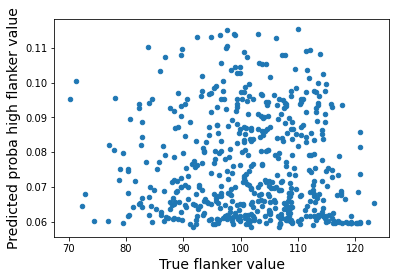

In [290]:
fig, ax = plt.subplots(1)
mscatter(y_flanker, y_high_proba[:,1], s=20, ax=ax)
plt.xlabel(f'True flanker value', fontsize=14)
plt.ylabel(f'Predicted proba high flanker value', fontsize=14)
plt.show()

# Compare clusterings

In [18]:
def clustering_af(points_TSNE):
    af = AffinityPropagation().fit(points_TSNE)
    cluster_labels_af = af.labels_
    x_cluster_label_af = af.predict(points_TSNE)
    initial_centers = af.cluster_centers_indices_
    n_clusters_ = len(initial_centers)
    while n_clusters_ > 5:
        af = AffinityPropagation().fit(points_TSNE[af.cluster_centers_indices_])
        cluster_labels_af = af.labels_
        x_cluster_label_af = af.predict(points_TSNE)
        n_clusters_ = len(af.cluster_centers_indices_)
        print(n_clusters_)
    clusters_centers_af = af.cluster_centers_

    print(f"Average silhouette score: {metrics.silhouette_score(points_TSNE, x_cluster_label_af)}")

    return x_cluster_label_af, cluster_labels_af, clusters_centers_af


In [20]:
x_cluster_label_af, cluster_labels_af, clusters_centers_af = clustering_af(X_tsne)

4
Average silhouette score: 0.4238118529319763


In [21]:
x_cluster_label_af2, cluster_labels_af2, clusters_centers_af2 = clustering_af(X_tsne2)

4
Average silhouette score: 0.44882825016975403


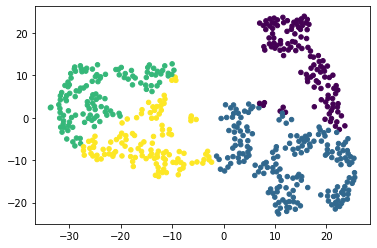

In [22]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=x_cluster_label_af, s=20, ax=ax)
plt.show()

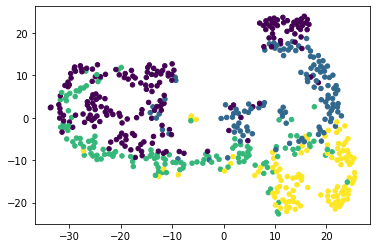

In [23]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=x_cluster_label_af2, s=20, ax=ax)
plt.show()

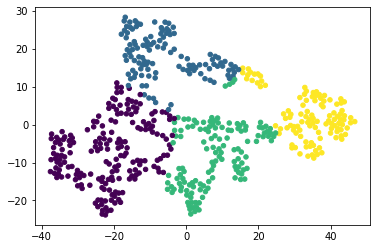

In [24]:
fig, ax = plt.subplots(1)
mscatter(X_tsne2[:, 0], X_tsne2[:, 1], c=x_cluster_label_af2, s=20, ax=ax)
plt.show()

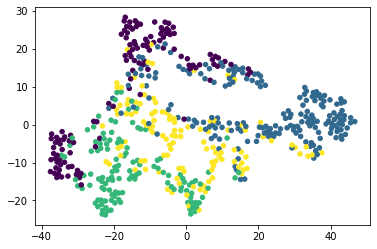

In [25]:
fig, ax = plt.subplots(1)
mscatter(X_tsne2[:, 0], X_tsne2[:, 1], c=x_cluster_label_af, s=20, ax=ax)
plt.show()

In [26]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_tsne)
cluster_labels_kmeans = kmeans.labels_
x_cluster_label_kmeans = kmeans.predict(X_tsne)
clusters_centroids_kmeans = kmeans.cluster_centers_
print(f"clusters centroids = {clusters_centroids_kmeans.shape}")
print(f"Average silhouette score: {metrics.silhouette_score(X_tsne, cluster_labels_kmeans)}")


clusters centroids = (10, 2)
Average silhouette score: 0.4572193920612335


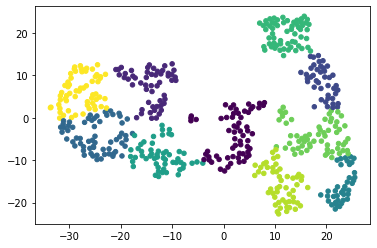

In [27]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=x_cluster_label_kmeans, s=20, ax=ax)
plt.show()

In [28]:
dbscan = DBSCAN(eps=2).fit(X_tsne)
cluster_labels_dbscan = dbscan.labels_
x_cluster_label_dbscan = dbscan.fit_predict(X_tsne)
print(f"Average silhouette score: {metrics.silhouette_score(X_tsne, cluster_labels_dbscan)}")


Average silhouette score: 0.01872294768691063


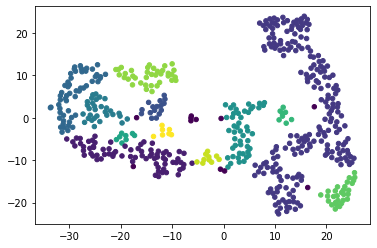

In [29]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=x_cluster_label_dbscan, s=20, ax=ax)
plt.show()

# 4) MA with AffinityPropagation clustering

In [30]:
x_cluster_label_af.shape

(550,)

In [31]:
dstrb_sub = pd.DataFrame(X_tsne, index=subject_labels, columns=[0,1])
dstrb_sub['af_label'] = x_cluster_label_af

In [32]:
dstrb_sub.head()

,0,1,af_label
129634,-25.234621,-6.989079,3
136833,-19.723698,-9.008698,3
206222,22.822351,-11.067300,1
138837,20.976093,-0.183199,0
987983,18.855858,10.753638,0


In [33]:
clusters_centroids = clusters_centers_af
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

cluster's centroids coordinates: 
 [[ 18.855858   10.753638 ]
 [ 10.188089  -10.928673 ]
 [-27.188335    6.992881 ]
 [-14.090506   -7.6115336]]


In [34]:
dstrb_sub.loc[dstrb_sub.index[0]]

0          -25.234621
1           -6.989079
af_label     3.000000
Name: 129634, dtype: float64

In [35]:
central_af = []
for i in range(clusters_centroids.shape[0]):
    central_af.append(closest_distance(clusters_centroids[i], dstrb_sub.drop(['af_label'], axis=1)))
    print(f"Closest subject to centroid of cluster {i} is {central_af[i]}")

Closest subject to centroid of cluster 0 is 987983
Closest subject to centroid of cluster 1 is 137633
Closest subject to centroid of cluster 2 is 146836
Closest subject to centroid of cluster 3 is 105216


In [184]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[0:2]]) for i in range(len(dstrb_sub))])

color_dict = {0: 'gold', 1:'darkorange', 2:'black', 3:'brown'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.af_label]):
    ix = np.where(dstrb_sub.af_label == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict[g], label = g)

for g in np.unique([dstrb_sub.af_label]):
    ax.scatter(clusters_centroids[g][0],
               clusters_centroids[g][1],
               color='black',
               marker='X',
               s=120)

plt.xlabel(f't-SNE dimension 1', fontsize=14)
plt.ylabel(f't-SNE dimension 2', fontsize=14)
plt.legend()
plt.show()

NameError: name 'dstrb_sub' is not defined

# Cluster stability

In [76]:
dstrb_sub = dstrb_sub.rename(columns={'af_label':'E1_label'})

In [77]:
dstrb_sub.head()

,0,1,E1_label
129634,-25.234621,-6.989079,3
136833,-19.723698,-9.008698,3
206222,22.822351,-11.067300,1
138837,20.976093,-0.183199,0
987983,18.855858,10.753638,0


In [78]:
dstrb_sub['E2_label'] = x_cluster_label_af2

In [79]:
dstrb_sub.head()

,0,1,E1_label,E2_label
129634,-25.234621,-6.989079,3,2
136833,-19.723698,-9.008698,3,2
206222,22.822351,-11.067300,1,3
138837,20.976093,-0.183199,0,1
987983,18.855858,10.753638,0,1


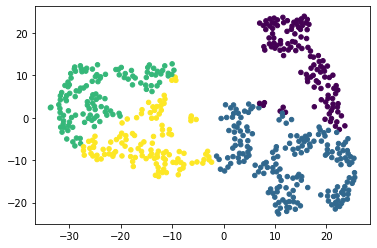

In [82]:
fig, ax = plt.subplots(1)
mscatter(dstrb_sub[0], dstrb_sub[1], c=dstrb_sub['E1_label'], s=20, ax=ax)
plt.show()

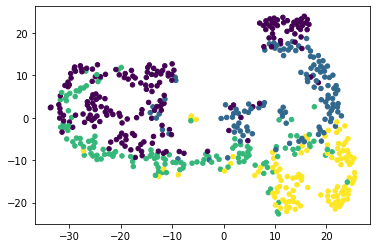

In [83]:
fig, ax = plt.subplots(1)
mscatter(dstrb_sub[0], dstrb_sub[1], c=dstrb_sub['E2_label'], s=20, ax=ax)
plt.show()

In [84]:
from sklearn.metrics import adjusted_mutual_info_score

In [114]:
adjusted_mutual_info_score(dstrb_sub['E1_label'], dstrb_sub['E2_label'], average_method='arithmetic')

0.3176057996999673

In [95]:
e1 = dstrb_sub['E1_label']
e2 = dstrb_sub['E2_label']

In [99]:
e1.head()

129634    3
136833    3
206222    1
138837    0
987983    0
Name: E1_label, dtype: int64

In [103]:
result = np.zeros((4,4))
result

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [112]:
for i in range(4):
    for j in range(4):
        e1_i = e1.mask(e1!=i, 5)
        e2_j = e2.mask(e2!=j, 5)
        result[i,j] = round(adjusted_mutual_info_score(e1_i, e2_j, average_method='arithmetic'),2)

In [113]:
result

array([[ 0.  ,  0.19,  0.11,  0.07],
       [ 0.22, -0.  , -0.  ,  0.31],
       [ 0.17,  0.12, -0.  ,  0.11],
       [-0.  ,  0.02,  0.06,  0.04]])

In [115]:
e1.head()

129634    3
136833    3
206222    1
138837    0
987983    0
Name: E1_label, dtype: int64

In [116]:
dstrb_sub.head()

,0,1,E1_label,E2_label
129634,-25.234621,-6.989079,3,2
136833,-19.723698,-9.008698,3,2
206222,22.822351,-11.067300,1,3
138837,20.976093,-0.183199,0,1
987983,18.855858,10.753638,0,1


In [117]:
type(e1)

pandas.core.series.Series